In [10]:
# Michael Wasserstein
# Plot_Post_Frontal_Event_Radar_Loop.ipynb
# 8/8/2023
# Script will plot a loop of the radar data for the event of interest so you can generate a loop of it

####### Usage #########
# Conda environment - Radar_env_2

import boto3
import botocore
import boto3
from boto.s3.connection import S3Connection 
import datetime
import tempfile
import pyart

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as PathEffects
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas
from cartopy.io.img_tiles import GoogleTiles
from shapely import geometry
from shapely.geometry import Point, Polygon
import xarray as xr

from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)
import wrf
import urllib.request
import json
import math
import os, sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u1371671/')

from Useful_Python_Functions import arrow_points, truncate_colormap
from map_script_2 import *
import pyproj

path = 12
run_number = '12'
# paths for data
base = '/uufs/chpc.utah.edu/common/home/'
home = base + 'u1371671/'
Fig_dir = home + 'WRF/Figures_{}/wrf_{}/Accumulated_Precipitation/'.format(path,run_number)
KMTX_path = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/michael/Radar/KMTX_lvl2_download2/2019/03/'
KMTX_files = glob.glob(KMTX_path + '*')

station = 'CLN'

# User Inputs
gatefilter = None
field = 'reflectivity'

In [2]:
# Vasiloff z-s relationship

# These results indicate that the new SAA will be
# an overall improvement to WSR-88D wintertime
# precipitation estimates in complex terrain. The primary
# benefit will be through the added flexibility of changing
# the Z-R/S relation depending on the situation. After the
# SAA is installed, it is recommended that the relation
# Z=75S2
#  be used everywhere with additional corrections
# previously described for mountains and valleys within
# ~100 km of the radar. 

In [3]:
# Subset for only files during event
KMTX_files_event = []
for file in KMTX_files:
    file_date = datetime.datetime.strptime((file.split('/')[-1].split('X')[-1].split('_V')[0]), '%Y%m%d_%H%M%S')
    if (file_date >= datetime.datetime(2019,3,22,12)) & (file_date <= datetime.datetime(2019,3,23,6)):
        KMTX_files_event.append(file)

In [4]:
######################## Plotting Stuff #####################
# Get colormap
cmap = plt.get_cmap('pyart_LangRainbow12')  # Radar colormap - colorblind friendly
cmap.set_under('none')

topo_levels = np.arange(1200,3000,500) # specify levels for plotting topograpy as a contour

datacrs = ccrs.PlateCarree()

In [5]:
# Initialize the accumulation array to None, or an array of zeros if you know the shape in advance
precipitation_accum_sum = None

########### End of user inputs ############
for i, f in enumerate(KMTX_files_event[0::]):

    #### DO the NECESSARY PYART STUFF ########
    radar = pyart.io.read_nexrad_archive(f)  # Read in file using pyart
    radar_location = radar.metadata['instrument_name']  # Get the location of the radar - should be KMTX
    
    radar_prior = pyart.io.read_nexrad_archive(KMTX_files_event[i-1])

    # Extract date and time for the radar, and create a string of them
    date = radar.time['units'][14:].split('T')[0]
    time = radar.time['units'][14:].split('T')[1]
    
    date_prior = radar_prior.time['units'][14:].split('T')[0]
    time_prior = radar_prior.time['units'][14:].split('T')[1]
    valid_time_prior = pd.to_datetime(date_prior + ' ' + time_prior)

    valid_time_KMTX = date + ' ' + time
    valid_time_dt = pd.to_datetime(valid_time_KMTX)
    valid_time_save = valid_time_dt.strftime('%Y%m%d%H%M%S')
    print(valid_time_prior, valid_time_save)
    time_difference = valid_time_dt - valid_time_prior
    time_diff_seconds = time_difference.total_seconds()# Convert to seconds
    
    # Hack for the first index having issues. just make it 335 seconds, similar to all the others
    if time_diff_seconds < 0:
        time_diff_seconds = 335.0
    print(time_diff_seconds)

    type_of_data = radar.metadata['original_container'] # Get type of data - should be NEXRAD Level II

    radar_lat, radar_lon = radar.latitude['data'][0], radar.longitude['data'][0] # Get lat and lon of the radar

    rad_altitude = radar.altitude['data'][0] # Get the altitude of the radar

    for sweep, angle in enumerate(radar.fixed_angle['data']):        # Loop through sweeps
        if np.round(angle, 1) == 0.5:                                # See if the given sweep is the 0.5 degree scan
            print('Sweep for 0.5 degree radar scan: ' + str(sweep))
            break                                                    # Stop the loop at the 0.5 deg scan

    # Get the slice at the sweep
    sweep_slice = radar.get_slice(sweep)

    # grab radar data 
    z = radar.get_field(sweep, field)

    # extract lat lons 
    lon = radar.gate_longitude['data'][sweep_slice, :]
    lat = radar.gate_latitude['data'][sweep_slice, :]

    # get the range and time
    ranges = radar.range["data"]
    time = radar.time["data"]

    # get azimuth
    az = radar.azimuth['data'][sweep_slice]
    # get order of azimuths 
    az_ids = np.argsort(az)

    # reorder azs so they are in order 
    az = az[az_ids]
    z = z[az_ids]
    lon = lon[az_ids]
    lat = lat[az_ids]
    time = time[az_ids]
    
    p_rate = np.sqrt(z.data / 75)
    
    precipitation_accum_time = (p_rate / 3600) * time_diff_seconds # convert to mm/second and multiply my number of seconds
    #print(lon)
    #print(precipitation_accum_time_mm)
    
    precipitation_accum_time = np.where(np.isnan(precipitation_accum_time), 0, precipitation_accum_time)
    
    # If this is the first iteration, initialize the accumulation array
    if precipitation_accum_sum is None:
        precipitation_accum_sum = precipitation_accum_time.copy()
    else:
        # Sum the precipitation for this time step to the accumulation array
        precipitation_accum_sum += precipitation_accum_time






2019-03-23 06:00:00+00:00 20190322120150
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:01:50+00:00 20190322120724
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:07:24+00:00 20190322121300
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:13:00+00:00 20190322121834
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:18:34+00:00 20190322122409
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:24:09+00:00 20190322122944
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:29:44+00:00 20190322123520
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:35:20+00:00 20190322124055
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:40:55+00:00 20190322124630
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:46:30+00:00 20190322125205
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:52:05+00:00 20190322125741
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 12:57:41+00:00 20190322130315
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:03:15+00:00 20190322130850
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:08:50+00:00 20190322131440
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:14:40+00:00 20190322132015
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:20:15+00:00 20190322132549
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:25:49+00:00 20190322133125
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:31:25+00:00 20190322133659
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:36:59+00:00 20190322134235
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:42:35+00:00 20190322134825
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:48:25+00:00 20190322135414
349.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 13:54:14+00:00 20190322140034
380.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:00:34+00:00 20190322140624
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:06:24+00:00 20190322141215
351.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:12:15+00:00 20190322141805
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:18:05+00:00 20190322142355
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:23:55+00:00 20190322142945
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:29:45+00:00 20190322143536
351.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:35:36+00:00 20190322144125
349.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:41:25+00:00 20190322144913
468.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:49:13+00:00 20190322145503
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 14:55:03+00:00 20190322150038
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:00:38+00:00 20190322150613
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:06:13+00:00 20190322151148
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:11:48+00:00 20190322151723
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:17:23+00:00 20190322152258
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:22:58+00:00 20190322152833
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:28:33+00:00 20190322153423
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:34:23+00:00 20190322154014
351.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:40:14+00:00 20190322154604
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:46:04+00:00 20190322155155
351.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:51:55+00:00 20190322155745
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 15:57:45+00:00 20190322160335
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:03:35+00:00 20190322160910
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:09:10+00:00 20190322161445
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:14:45+00:00 20190322162020
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:20:20+00:00 20190322162555
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:25:55+00:00 20190322163131
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:31:31+00:00 20190322163706
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:37:06+00:00 20190322164241
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:42:41+00:00 20190322164817
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:48:17+00:00 20190322165407
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:54:07+00:00 20190322165956
349.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 16:59:56+00:00 20190322170547
351.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:05:47+00:00 20190322171122
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:11:22+00:00 20190322171656
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:16:56+00:00 20190322172232
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:22:32+00:00 20190322172807
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:28:07+00:00 20190322173343
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:33:43+00:00 20190322173918
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:39:18+00:00 20190322174454
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:44:54+00:00 20190322175029
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:50:29+00:00 20190322175604
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 17:56:04+00:00 20190322180139
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:01:39+00:00 20190322180716
337.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:07:16+00:00 20190322181250
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:12:50+00:00 20190322181826
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:18:26+00:00 20190322182401
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:24:01+00:00 20190322182936
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:29:36+00:00 20190322183512
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:35:12+00:00 20190322184046
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:40:46+00:00 20190322184622
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:46:22+00:00 20190322185156
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:51:56+00:00 20190322185732
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 18:57:32+00:00 20190322190337
365.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:03:37+00:00 20190322190927
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:09:27+00:00 20190322191517
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:15:17+00:00 20190322192121
364.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:21:21+00:00 20190322192726
365.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:27:26+00:00 20190322193330
364.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:33:30+00:00 20190322193950
380.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:39:50+00:00 20190322194610
380.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:46:10+00:00 20190322195229
379.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:52:29+00:00 20190322195849
380.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 19:58:49+00:00 20190322200510
381.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:05:10+00:00 20190322201132
382.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:11:32+00:00 20190322201806
394.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:18:06+00:00 20190322202426
380.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:24:26+00:00 20190322203046
380.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:30:46+00:00 20190322203706
380.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:37:06+00:00 20190322204312
366.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:43:12+00:00 20190322204918
366.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:49:18+00:00 20190322205507
349.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 20:55:07+00:00 20190322210059
352.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:00:59+00:00 20190322210648
349.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:06:48+00:00 20190322211223
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:12:23+00:00 20190322211758
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:17:58+00:00 20190322212334
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:23:34+00:00 20190322212909
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:29:09+00:00 20190322213444
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:34:44+00:00 20190322214018
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:40:18+00:00 20190322214553
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:45:53+00:00 20190322215129
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:51:29+00:00 20190322215719
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 21:57:19+00:00 20190322220309
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:03:09+00:00 20190322220845
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:08:45+00:00 20190322221420
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:14:20+00:00 20190322221955
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:19:55+00:00 20190322222529
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:25:29+00:00 20190322223106
337.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:31:06+00:00 20190322223655
349.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:36:55+00:00 20190322224230
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:42:30+00:00 20190322225008
458.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:50:08+00:00 20190322225543
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 22:55:43+00:00 20190322230119
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:01:19+00:00 20190322230654
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:06:54+00:00 20190322231229
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:12:29+00:00 20190322231805
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:18:05+00:00 20190322232356
351.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:23:56+00:00 20190322232947
351.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:29:47+00:00 20190322233537
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:35:37+00:00 20190322234142
365.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:41:42+00:00 20190322234748
366.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:47:48+00:00 20190322235353
365.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-22 23:53:53+00:00 20190323000011
378.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:00:11+00:00 20190323000616
365.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:06:16+00:00 20190323001222
366.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:12:22+00:00 20190323001826
364.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:18:26+00:00 20190323002416
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:24:16+00:00 20190323003006
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:30:06+00:00 20190323003556
350.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:35:56+00:00 20190323004132
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:41:32+00:00 20190323004707
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:47:07+00:00 20190323005243
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:52:43+00:00 20190323005818
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 00:58:18+00:00 20190323010353
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:03:53+00:00 20190323010928
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:09:28+00:00 20190323011503
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:15:03+00:00 20190323012039
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:20:39+00:00 20190323012614
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:26:14+00:00 20190323013149
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:31:49+00:00 20190323013724
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:37:24+00:00 20190323014300
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:43:00+00:00 20190323014835
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:48:35+00:00 20190323015410
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:54:10+00:00 20190323015946
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 01:59:46+00:00 20190323020521
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:05:21+00:00 20190323021056
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:10:56+00:00 20190323021632
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:16:32+00:00 20190323022207
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:22:07+00:00 20190323022742
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:27:42+00:00 20190323023317
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:33:17+00:00 20190323023853
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:38:53+00:00 20190323024427
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:44:27+00:00 20190323025002
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:50:02+00:00 20190323025537
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 02:55:37+00:00 20190323030113
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:01:13+00:00 20190323030648
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:06:48+00:00 20190323031224
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:12:24+00:00 20190323031800
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:18:00+00:00 20190323032335
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:23:35+00:00 20190323032910
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:29:10+00:00 20190323033446
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:34:46+00:00 20190323034021
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:40:21+00:00 20190323034557
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:45:57+00:00 20190323035132
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:51:32+00:00 20190323035707
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 03:57:07+00:00 20190323040242
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:02:42+00:00 20190323040816
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:08:16+00:00 20190323041352
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:13:52+00:00 20190323041927
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:19:27+00:00 20190323042503
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:25:03+00:00 20190323043038
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:30:38+00:00 20190323043613
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:36:13+00:00 20190323044149
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:41:49+00:00 20190323044723
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:47:23+00:00 20190323045259
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:52:59+00:00 20190323045834
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 04:58:34+00:00 20190323050409
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:04:09+00:00 20190323050945
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:09:45+00:00 20190323051520
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:15:20+00:00 20190323052055
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:20:55+00:00 20190323052629
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:26:29+00:00 20190323053205
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:32:05+00:00 20190323053741
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:37:41+00:00 20190323054315
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:43:15+00:00 20190323054851
336.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:48:51+00:00 20190323055425
334.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


2019-03-23 05:54:25+00:00 20190323060000
335.0
Sweep for 0.5 degree radar scan: 0


/scratch/local/u1371671/1878577/ipykernel_1691042/29015199.py:70: RuntimeWarning: invalid value encountered in sqrt
  p_rate = np.sqrt(z.data / 75)


In [6]:
########################################
# For testing crazy wrf9 values
# Comment out if not testing
levels = [1,2,3,4,5,6,7,9,11,13,15,18,]
#levels = np.arange(1, 36, 2)
import matplotlib
cmap = matplotlib.cm.get_cmap('pyart_HomeyerRainbow')
vals = np.linspace(0,1,len(levels))
cols = [cmap(val) for val in vals]
########################################

/scratch/local/u1371671/1878577/ipykernel_1691042/3416821847.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('pyart_HomeyerRainbow')


In [11]:
start_time_save = datetime.datetime(2019,3,22,12).strftime('%Y%m%d%H%M') 
end_time_save = datetime.datetime(2019,3,23,6).strftime('%Y%m%d%H%M')
domain = 3
accumulation_time_hours = 18

In [12]:
save_path = Fig_dir + 'WRF_Accum_Precip_d{:02}_{:02}h_{}_{}.png'.format(domain, np.round(accumulation_time_hours, 1), start_time_save, end_time_save)

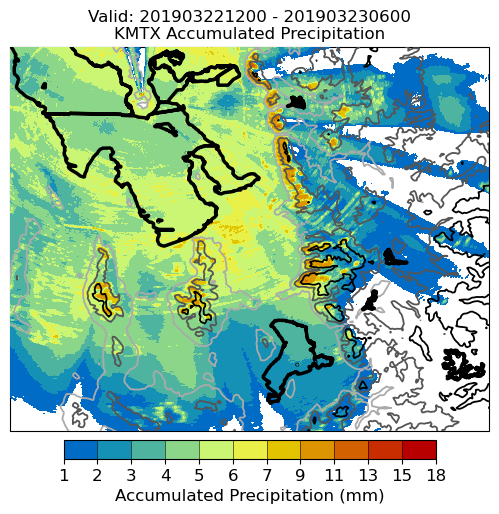

In [13]:
# Plotting
# Create figure and axis
fig, (ax1) = plt.subplots(1,1,figsize = (8, 6), subplot_kw= {'projection' : ccrs.PlateCarree()}, facecolor = 'white', edgecolor = 'k')

# Plot Reflectivity data
plot = ax1.contourf(lon, lat, precipitation_accum_sum, levels = levels, colors = cols, zorder = 15)

# Plot Lakes
ax1.add_geometries(lakes_gdf.geometry, ccrs.PlateCarree(), zorder = 150, facecolor='none',
            edgecolor = 'black', linewidth = 2.5)

# Plot Topography
contour = ax1.contour(lons,lats, topo, zorder = 100, levels = topo_levels, cmap = 'binary', linewidths = 1.3, )#colors = 'black',)

# Titles
ax1.set_title('Valid: ' + datetime.datetime(2019,3,22,12).strftime('%Y%m%d%H%M') 
              + ' - ' + datetime.datetime(2019,3,23,6).strftime('%Y%m%d%H%M') + '\n' +
              radar_location +' Accumulated Precipitation', loc = 'center')
#ax1.set_title(radar_location + ' ' + type_of_data + ' Composite Reflectivity', loc = 'left')
# ax1.set_title(, loc = 'left')

# Set limits
ax1.set_xlim(-113, -111)
ax1.set_ylim(39.9, 41.5)

# Add colorbar
# cax = plt.axes([0.19,0.06, 0.65, 0.03])
# cb = plt.colorbar(plot, cax = cax, pad=0.01, aspect=40, extend='max', shrink=0.5, orientation = 'horizontal')
# cb.ax.tick_params(length=8, width=.25, pad=0.01)
# cb.set_label('Accumulated Precipitation (mm)', labelpad=8, y=0.5, fontsize = 14)
# #cb.ax.set_xticks(np.arange(0, 10+.01, 4).astype(int), labels = np.arange(0, 32+.01, 4).astype(str), fontsize=14)

fsize = 12

# Colorbar stuff
cb = plt.colorbar(plot, ax=ax1, shrink=.6, pad=0.02, drawedges=True, orientation='horizontal', ticks = levels)
cb.ax.tick_params(labelsize=fsize)
cb.set_label("Accumulated Precipitation (mm)", fontsize=fsize)



plt.savefig(save_path, dpi = 200, bbox_inches = 'tight')
plt.show()
plt.close()